# Tutorial: Quick Start

This tutorial will walk you through the steps needed to emulate k-table mixing using a DeepSet. If you require more understanding of the individual steps, hover over to the code or the API documentation here.

At the end of this tuturial, you will know how to deploy the DeepSet to your radiative transfer solver.

## Setup

In [1]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.emulator import Emulator, DEFAULT_MMR_RANGES

%matplotlib inline

2023-10-12 13:50:28.780493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# DEFAULT_MMR_RANGES = {
#     'CO': (1e-20, 0.005522337070205542),
#     'H2O': (1e-20, 0.0057565911404275204),
#     'HCN': (1e-20, 9.103077483740115e-05),
#     'C2H2,acetylene': (1e-20, 1.581540423097846e-05),
#     'CH4': (1e-20, 0.0031631031028604537),
#     'PH3': (1e-20, 6.401082202603451e-06),
#     'CO2': (1e-20, 0.00015319944152172055),
#     'NH3': (1e-20, 0.00084362326521647),
#     'H2S': (1e-20, 0.0003290905470710346),
#     'VO': (1e-20, 1.6153195092178982e-07),
#     'TiO': (1e-20, 3.925184850731112e-06),
#     'Na': (1e-20, 2.524986071526357e-05),
#     'K': (1e-20, 1.932224843084919e-06),
#     'SiO': (1e-20, 0.0010448970102509476),
#     'FeH': (1e-20, 0.000203477300968298)
# }

We first set some parameters

In [3]:
batchsize = int(8e5)  # approximate number of kappa(g) that we can use for learning

load = False  # load the kappas or mix them again
load_model = False  # load the ML model from file or start training from scratch

`opac_mixer` can currently deal with [ExomolOP](https://www.aanda.org/articles/aa/full_html/2021/02/aa38350-20/aa38350-20.html) files created for petitRADTRANS. You can use exo-k to bin them down to lower resolution. There is a tutorial available for this in the `petitRADTRANS` docs [(here)](https://petitradtrans.readthedocs.io/en/latest/content/notebooks/Rebinning_opacities.html).

In [4]:
# Setup the opacity files and prepare the reader instance
# R_10='10'
R_S1='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
# files_10 = glob.glob(os.path.join(base,f'*_R_{R_10}/*.h5'))
files_S1 = glob.glob(os.path.join(base,f'*_R_{R_S1}/*.h5'))
# opac_10 = ReadOpacChubb(files_10)
opac_S1 = ReadOpacChubb(files_S1)

Setup the emulator object. You can also use a set of readers for the emulator (e.g., multiple resolutions).

In [5]:
# em = Emulator([opac_10, opac_S1], filename_data='data/mix_S1_10.h5')
em = Emulator(opac_S1, filename_data='data/mix_S1.h5')

There are a few things to do now:

0. (optional) setup a grid of extra abundancies (eq. chem.) for training also on eq.chem. and not just on random abundancies
1. setup the sampling grid (this is the input data)
2. setup the mix (e.g., mix the opacities to get the y's for your ML model to learn)
3. Decide on a scaling function for model input and output (useful)

In [6]:
# Optional: Setup eq. chem mass mixing ratios to train hybrid on eq chem and random abundancies
from petitRADTRANS.poor_mans_nonequ_chem import interpol_abundances
from itertools import product

COs = [0.55, 0.3, 0.8]
FeHs = [-1.0, 0.0, 1.0]

extra_abus = np.empty((len(COs)*len(FeHs), opac_S1.ls, opac_S1.lp[0], opac_S1.lt[0]))
for i, (CO, FeH) in enumerate(product(COs, FeHs)):
    for ti,t in enumerate(opac_S1.Tr):
        COs_i = CO * np.ones_like(opac_S1.pr)
        FeHs_i = FeH * np.ones_like(opac_S1.pr)
        temp = t * np.ones_like(opac_S1.pr)
        abus = interpol_abundances(COs_i, FeHs_i, temp, opac_S1.pr)
        extra_abus[i,:,:,ti] = np.array([abus[sp] for sp in opac_S1.spec])

In [7]:
em.setup_sampling_grid(approx_batchsize=batchsize, bounds=DEFAULT_MMR_RANGES, extra_abus = extra_abus)
if not load:
    if __name__ == "__main__":
        em.setup_mix()
else:
    em.load_data()
em.setup_scaling()

  0%|          | 0/88 [00:00<?, ?it/s]2023-10-12 13:51:12.322735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:51:12.322752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:51:12.325242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  S

## Fiting

Setup the model and fit it!

In [8]:
em.setup_model(learning_rate=1e-3, load=load_model, filename='data/mix_S1')
em.fit()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, None, 16)          0         
                                                                 
 dense (Dense)               (None, None, 16)          256       
                                                                 
 lambda (Lambda)             (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                256       
                                                                 
Total params: 512
Trainable params: 512
Non-trainable params: 0
_________________________________________________________________


2023-10-12 13:51:43.799285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch: 0, loss: 1.12e+02, val_error: (train - 3.78e-01, 9.91e-01); (test - 3.53e-01, 9.92e-01)
Epoch: 1, loss: 2.91e-01, val_error: (train - 2.72e-01, 9.93e-01); (test - 2.60e-01, 9.94e-01)
Epoch: 2, loss: 2.48e-01, val_error: (train - 2.56e-01, 9.94e-01); (test - 2.43e-01, 9.94e-01)
Epoch: 3, loss: 2.37e-01, val_error: (train - 2.57e-01, 9.94e-01); (test - 2.39e-01, 9.94e-01)
Epoch: 4, loss: 2.33e-01, val_error: (train - 2.55e-01, 9.94e-01); (test - 2.44e-01, 9.94e-01)
Epoch: 5, loss: 2.29e-01, val_error: (train - 2.61e-01, 9.94e-01); (test - 2.34e-01, 9.94e-01)
Epoch: 6, loss: 2.27e-01, val_error: (train - 2.36e-01, 9.94e-01); (test - 2.22e-01, 9.95e-01)
Epoch: 7, loss: 2.24e-01, val_error: (train - 2.30e-01, 9.94e-01); (test - 2.13e-01, 9.95e-01)
Epoch: 8, loss: 2.23e-01, val_error: (train - 2.36e-01, 9.94e-01); (test - 2.20e-01, 9.95e-01)
Epoch: 9, loss: 2.21e-01, val_error: (train - 2.36e-01, 9.94e-01); (test - 2.21e-01, 9.95e-01)
Epoch: 10, loss: 2.21e-01, val_error: (train - 2.2

INFO:tensorflow:Assets written to: data/mix_S1/assets


INFO:tensorflow:Assets written to: data/mix_S1/assets


## Plotting

Plot the weights

In [9]:
em.plot_weights(do_log=True)

ValueError: 'linscale' must be positive

Plot the predictions

4950/4950 [==============================] - 4s 750us/step


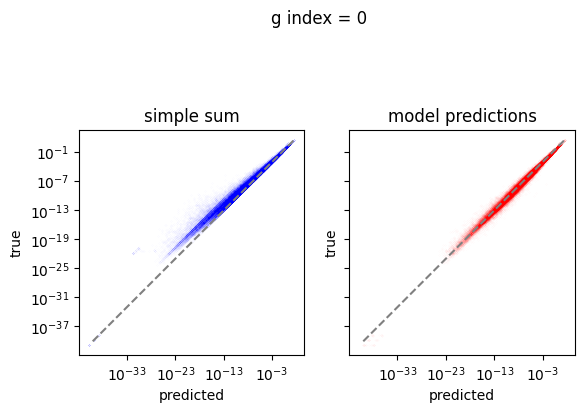

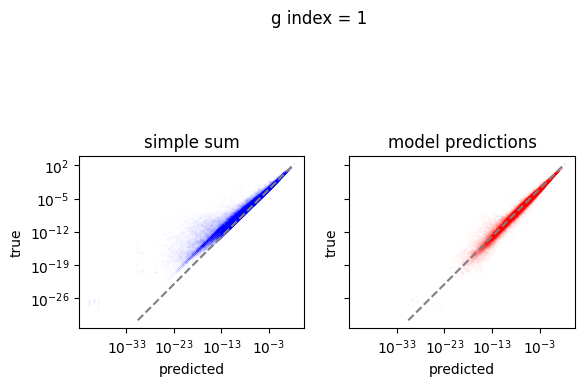

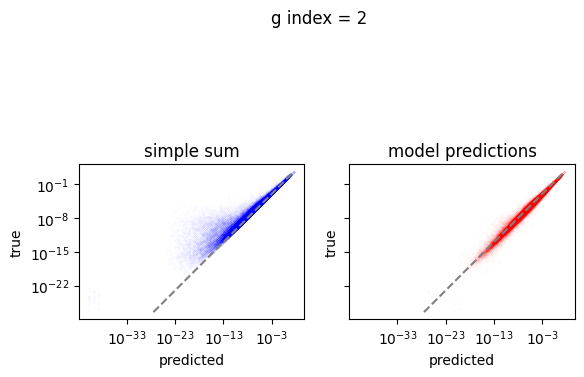

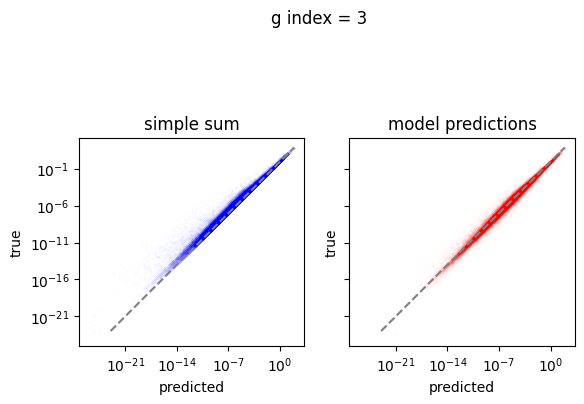

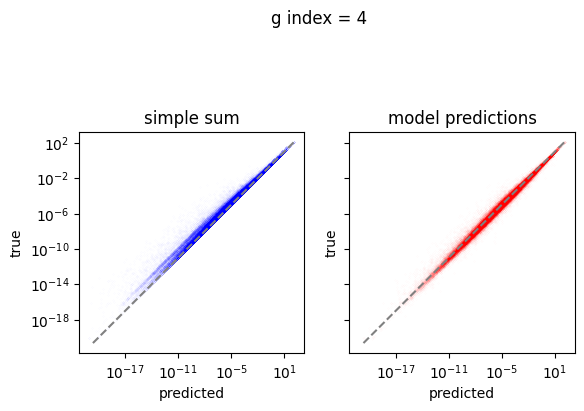

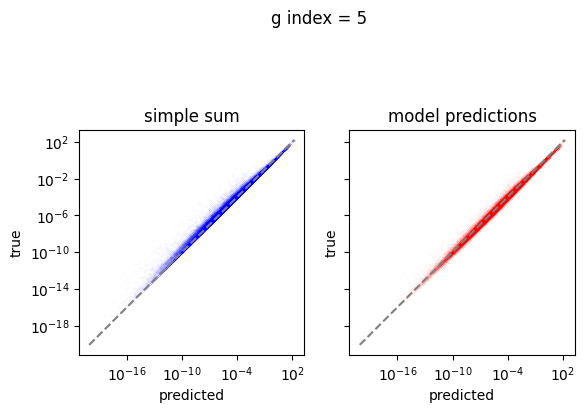

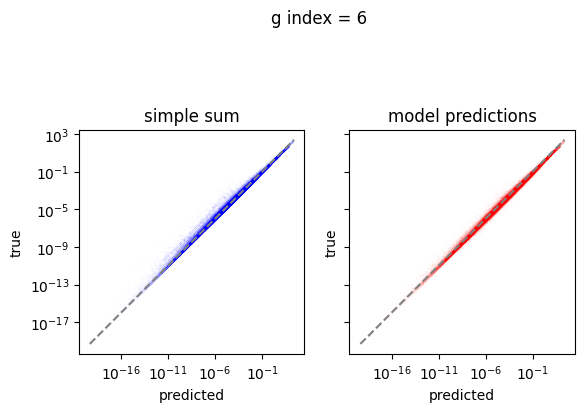

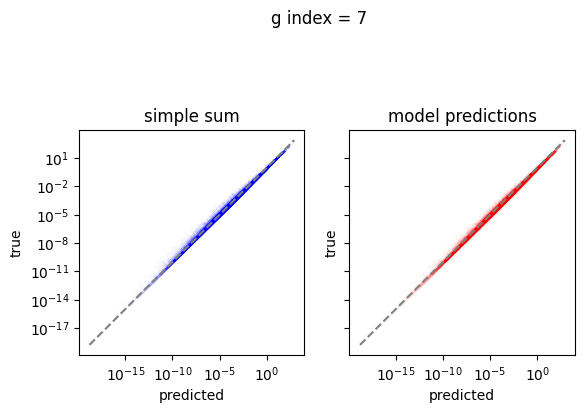

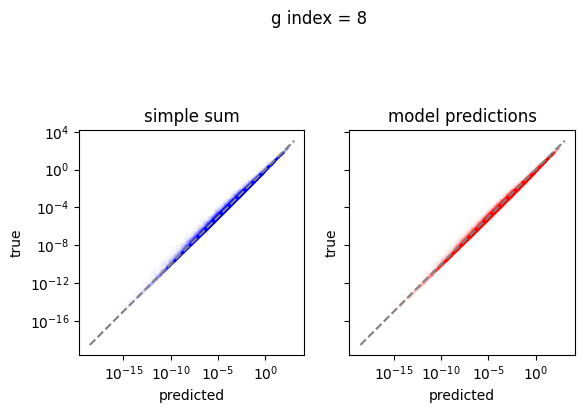

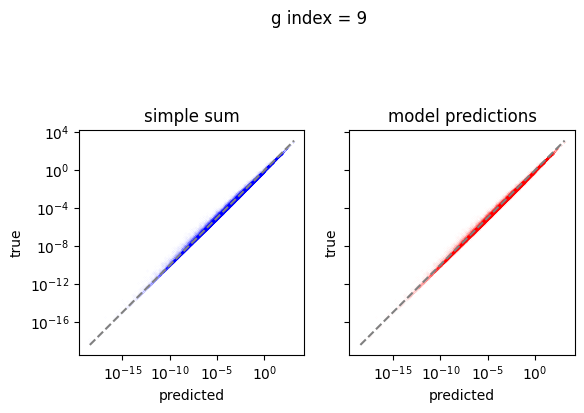

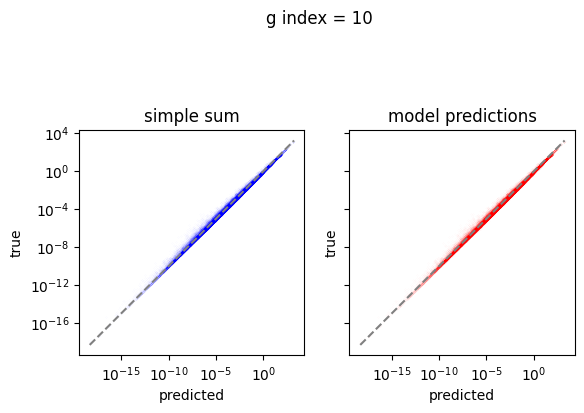

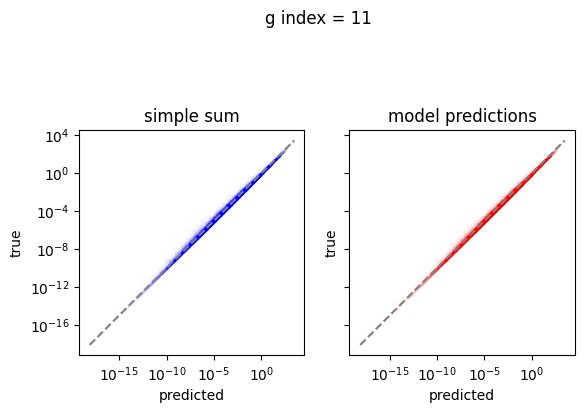

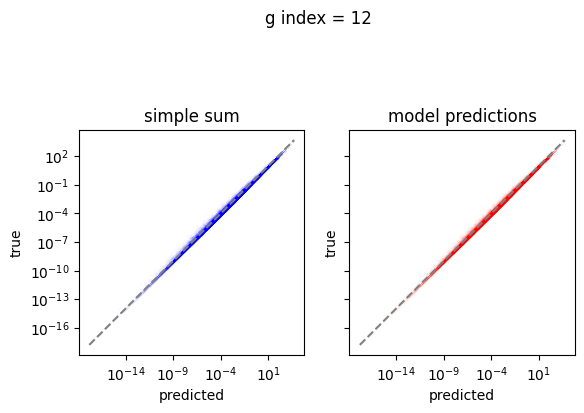

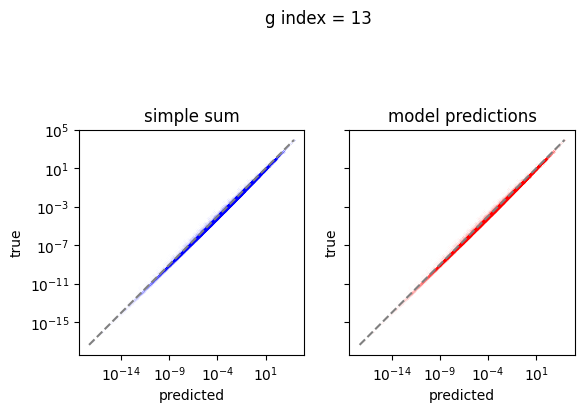

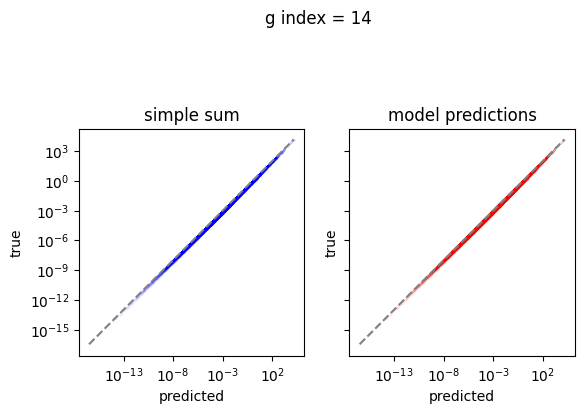

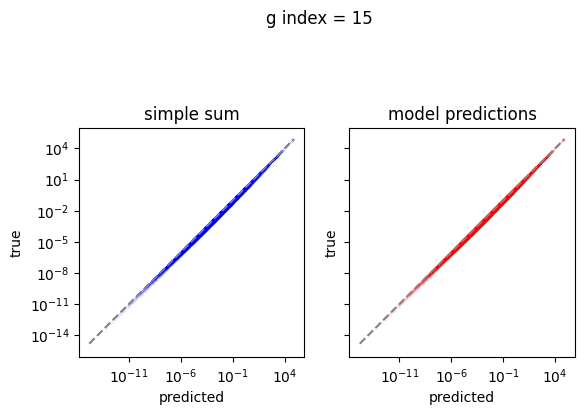

In [10]:
em.plot_predictions()

Export the model to exorad and numpy

In [13]:
em.export('data/mix_S1/',file_format='np')
em.export('data/mix_S1/',file_format='exorad')

em.export('/Users/schneider/codes/exo/exorad/verification/HD2/input',file_format='exorad')
em.export('/Users/schneider/codes/exo/exorad/verification/fluxes/input',file_format='exorad')

## simple numpy implementation

Here is a simple numpy implementation of the DeepSet

In [14]:
mlp_weights = [weights.numpy() for weights in em.model.weights]
def simple_mlp(kappas):
    rep = np.tensordot(kappas, mlp_weights[0], axes=(1,0))  # first dense
    rep[rep <= 0.0] = 0.0
    sum_rep = np.sum(rep, axis=1)   # sum
    dec = np.tensordot(sum_rep, mlp_weights[1], axes=(-1,0))  # second dense
    return dec